## Open, Plot and Explore Lidar Data in Raster Format with Python

### What is a Raster?
Raster or “gridded” data are stored as a grid of values which are rendered on a map as pixels. Each pixel value represents an area on the Earth’s surface. A raster file is a composed of regular grid of cells, all of which are the same size. You’ve looked at and used rasters before if you’ve looked at photographs or imagery in a tool like Google Earth. However, the raster files that you will work with are different from photographs in that they are spatially referenced. Each pixel represents an area of land on the ground. That area is defined by the spatial resolution of the raster.

<img src="images/raster-concept.png" alt="drawing" width="800"/>

## Raster Facts

A few notes about rasters:

* Each cell is called a pixel.

* And each pixel represents an area on the ground.

* The resolution of the raster represents the area that each pixel represents the area it represents on the ground. So, a 1 meter resolution raster, means that each pixel represents a 1 m by 1m area on the ground.

A raster dataset can have attributes associated with it as well. For instance in a LiDAR derived digital elevation model (DEM), each cell represents an elevation value for that location on the earth. In a LIDAR derived intensity image, each cell represents a LIDAR intensity value or the amount of light energy returned to and recorded by the sensor.

<img src="images/raster-resolution.png" alt="drawing" width="1000"/>

## Open Raster Data in Python

You can use the `rasterio` library combined with `numpy` and `matplotlib` to open, manipulate and plot raster data in Python. To begin you will load a suite of python libraries required to complete this lesson. These libraries are all a part of the `uq-geo` conda environment.

In [82]:
import geopandas as gpd
from geopandas.tools import sjoin
import matplotlib.pyplot as plt
import contextily as cx
import rasterio as rio
from rasterstats import zonal_stats

Be sure to set your working directory `os.chdir("path-to-you-dir-here/uq-geo-python/data")`

In [83]:
os.chdir(os.path.join('/home/tim/uq-geo-python'))

height_raster_path = 'data/GEDI_LandSat_Raster/Forest_Height_2019.tif'

# open raster data
height_raster = rio.open(height_raster_path)

# view spatial extent
lidar_dem.bounds

BoundingBox(left=152.4025, bottom=-27.52375, right=152.99025, top=-26.87625)

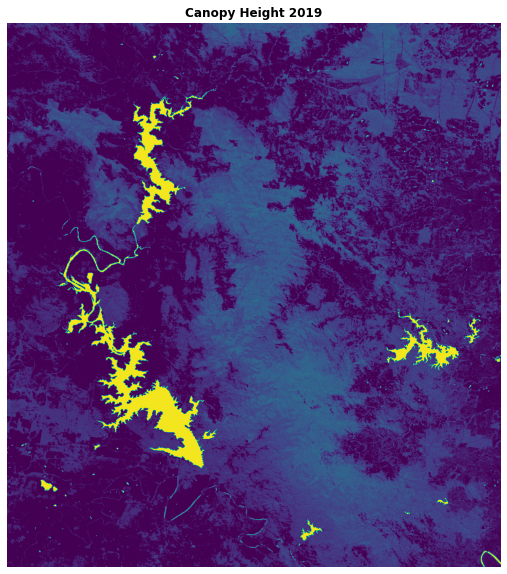

In [87]:
# plot the raster using matplotlib

fig, ax = plt.subplots(figsize = (10,10))
show(height_raster, 
     title="Canopy Height 2019", 
     ax=ax)
ax.set_axis_off()

### Opening and Closing File Connections
The rasterio library is efficient as it establishes a connection with the raster file rather than directly reading it into memory. Because it creates a connection, it is important that you close the connection after it is opened AND after you’ve finished working with the data!

In [60]:
# close the file connection
height_raster.close()

In [61]:
# this returns an error as you have closed the connection to the file. 
show(height_raster)

RasterioIOError: Dataset is closed: data/GEDI_LandSat_Raster/Forest_Height_2019.tif

Once the connection is closed, you can no longer work with the data. You’ll need to re-open the connection. Like this:

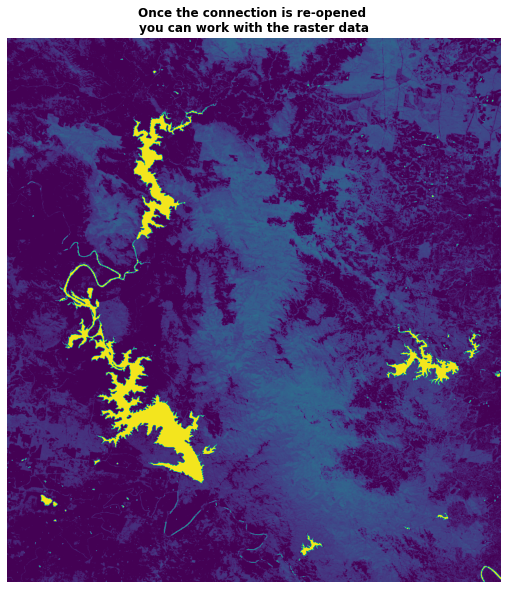

In [62]:
# open raster data connection - again
height_raster = rio.open(height_raster_path)

fig, ax = plt.subplots(figsize = (10,10))
show(height_raster, 
     title="Once the connection is re-opened \nyou can work with the raster data", 
     ax=ax)
ax.set_axis_off()

You can use the rasterio show() function to quickly plot a raster image.

In [63]:
height_raster.close()

### Context Manager to Open/Close Raster Data

A better way to work with raster data in `rasterio` is to use the context manager. This will handle opening and closing the raster file for you.

`with rio.open('name of file') as scr: src.rasteriofunctionname()`

In [65]:
# view spatial extent of raster object
with rio.open(height_raster_path) as src:
    print(src.bounds)

BoundingBox(left=152.4025, bottom=-27.52375, right=152.99025, top=-26.87625)


Once you are outside of the `with` statement, you can no long access the `src` object which contains the spatial raster information.

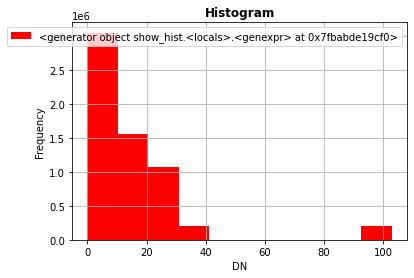

In [95]:
rio.plot.show_hist(height_raster)

### Raster Plots with Matplotlib
Let’s try this again. Open the same DEM using a context manager. Then let’s plot again but this time using earthpy `plot_bands`. Using `matplotlib` allows you to fully customize your plots. Do the following

1. use .read() to read in your raster data as a numpy array
2. set masked = True to ensure that no data values get translated to `nan`.
3. only read in the first band of your single band image. If you don’t specify `1` when you read in a raster you will get a 3 dimensional array.

In [67]:
# read in all of the data without specifying a band
with rio.open(height_raster_path) as src:
    # convert / read the data into a numpy array:
    lidar_dem_im = src.read(masked= True)
    
# view array shape -- notice that you have 3 dimensions below
print(lidar_dem_im.shape)

(1, 2590, 2351)


In [71]:
# specify a band so you get a 2 dimensional image array
with rio.open(height_raster_path) as src:
    # convert / read the data into a numpy array:
    height_raster_im = src.read(1, masked= True)
    height_raster_ext = rio.plot.plotting_extent(src)
    
# view array shape -- here you have a 2 dimensional array as you would expect to have
print(height_raster_im.shape)

(2590, 2351)


In [72]:
height_raster_ext

(152.4025, 152.99025, -27.52375, -26.87625)

### Plot A Raster Using EarthPy

You are now ready to plot your data using `plot_bands` and EarthPy.

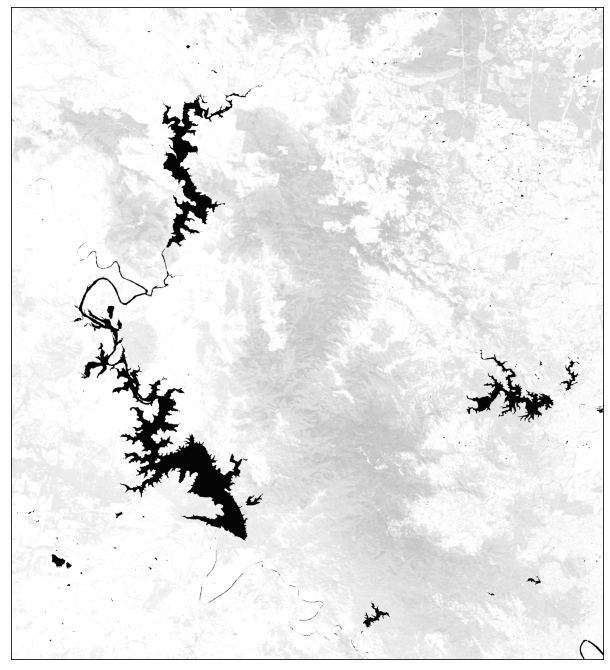

<AxesSubplot:>

In [73]:
ep.plot_bands(height_raster_im,
              cmap='Greys',
              extent=height_raster_ext,
              cbar=False)

The earthpy plot_bands function allows you to quickly plot one or more bands of a raster. This image shows a DEM generated from lidar data.

If you provide the spatial extent of the raster to the plot, it will be plotted in the correct spatial location. This is important if you plan to overlay another spatial data layer on top of your raster plot.

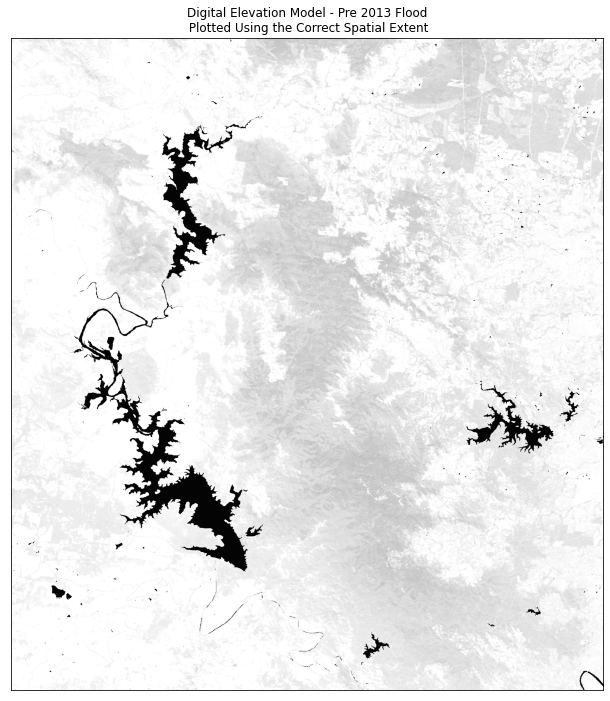

In [75]:
ep.plot_bands(height_raster_im,
              cmap='Greys',
              extent=height_raster_ext,
              cbar=False,
              # Add a title arguement
              title="Digital Elevation Model - Pre 2013 Flood\n Plotted Using the Correct Spatial Extent")
plt.show()

The earthpy plot_bands function can be customized to address colormaps and titles as well. This image shows a DEM generated from lidar data.

Adding a `;` at the end of the last line of your plot will turn off the message that you might otherwise get from matplotline: `Text(0.5,1,'Digital Elevation Model - Pre 2013 Flood')`

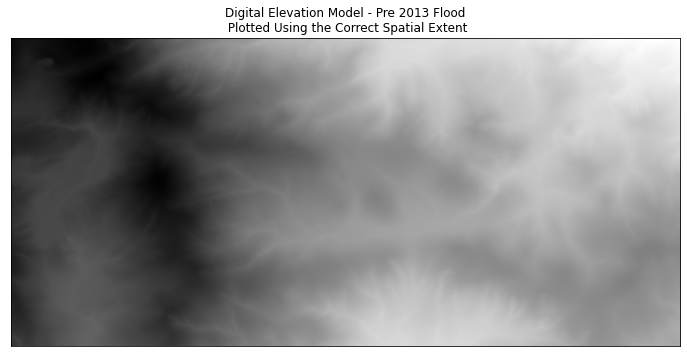

In [29]:
ep.plot_bands(lidar_dem_im,
              cmap='Greys',
              extent=sjer_ext,
              title="Digital Elevation Model - Pre 2013 Flood\n Plotted Using the Correct Spatial Extent",
              cbar=False)
plt.show()

The earthpy plot_bands function allows you to quickly plot one or more bands of a raster. This image shows a DEM generated from lidar data.

Let’s plot again but this time you will:

1. add a colorbar by allowing `ep.plot_bands()` to add one. You have been setting the `cbar` arguement to False in the previous plots. The default for `plot_bands()` is for `cbar` to be set to `True`
2. fix the colorbar scaling. By default, `plot_bands()` will scale a colorbar to a 0-255 scale. However, since you are looking at elevation data, you would like the original values of the raster. You can prevent this scaling by setting the `scale` arguement of `plot_bands()` to `False`
3. turn off the annoying matplotlib message by adding a semicolon `;` to the end of the last line

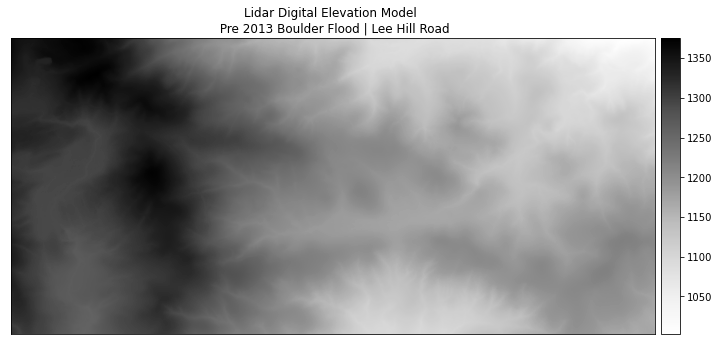

In [30]:
ep.plot_bands(lidar_dem_im,
              cmap='Greys',
              extent=sjer_ext,
              title="Lidar Digital Elevation Model \n Pre 2013 Boulder Flood | Lee Hill Road",
              scale=False)
plt.show()

The earthpy plot_bands function allows you to quickly plot one or more bands of a raster. This image shows a DEM generated from lidar data.

Below you tweak the height of your colorbar to ensure it lines up with the top and bottom edges of your plot. To do this you use the make_axes_locatable package from the mpl_toolkits.axes_grid1 library.

To plot you can select pre-determined color ramps from `matplotlib`, you can reverse a color ramp by adding `_r` at the end of the color ramps name, for example `cmap = 'viridis_r'`.

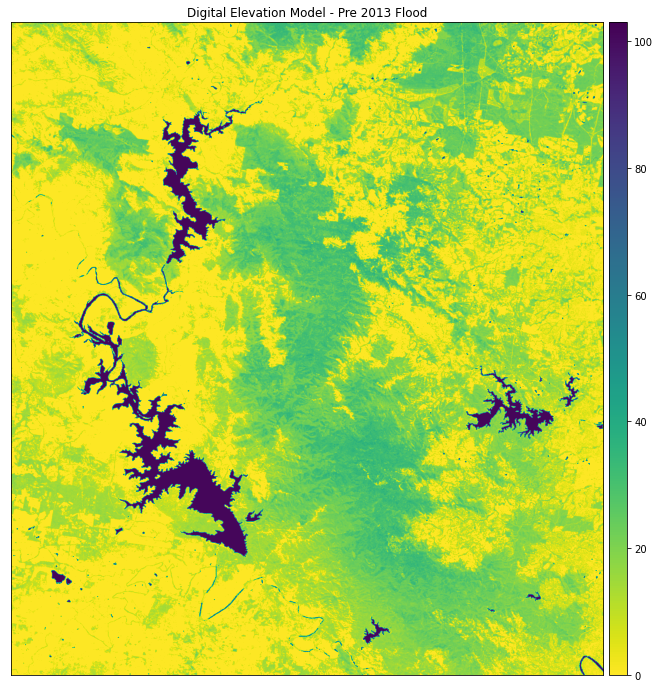

In [77]:
ep.plot_bands(height_raster_im,
              cmap='viridis_r',
              extent=height_raster_ext,
              title="Digital Elevation Model - Pre 2013 Flood",
              scale=False)
plt.show()

Here, the colormap is modified and a colorbar is turned on when using the plot_bands function.

### Explore Raster Data Values with Histograms
Next, you will explore a histogram of your data. A histogram is useful to help you better understand the distribution of values within your data. In this case given you are looking at elevation data, if there are all small elevation values and the histogram looks uniform (not too much variation in values) you can assume that your study area is relative “flat” - not too hilly. If there is a different distribution of elevation values you can begin to understand the range of elevation values in your study area and the degree of difference between low and high regions (ie is it flat or hilly?). Is it high elevation vs low elevation?

To plot a histogram use the `earthpy.plot` - `hist()` function.

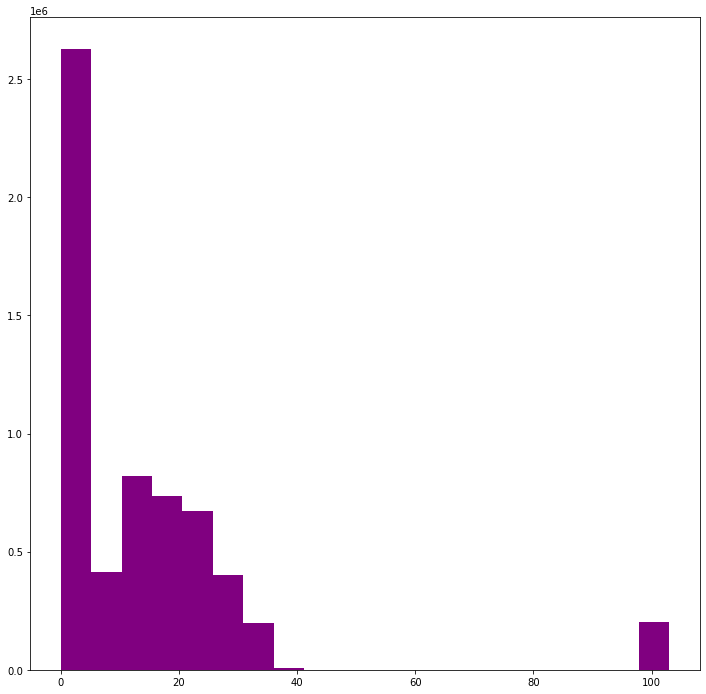

In [78]:
# create histogram of data
ep.hist(height_raster_im)
plt.show()

The earthpy hist function allows you to quickly view the distribution of pixel values for 1 or more bands of a raster.

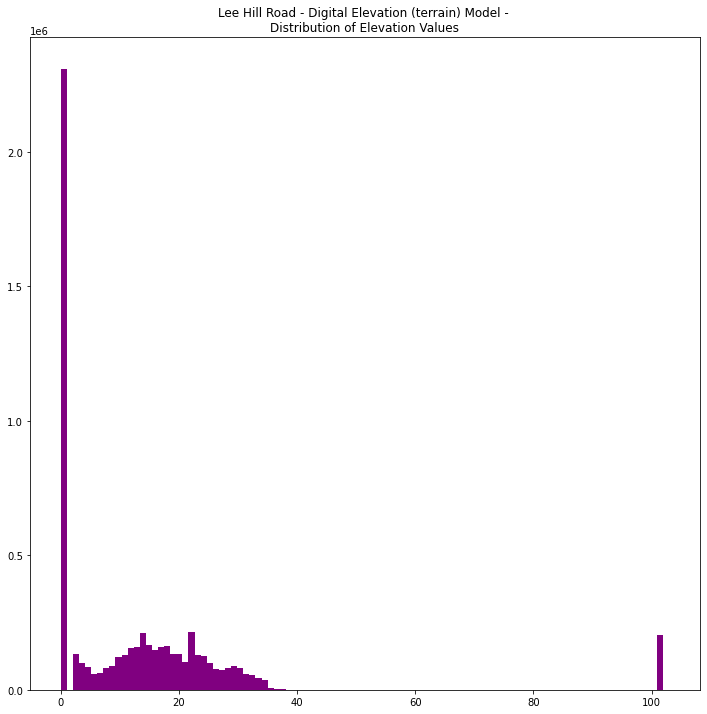

In [79]:
# create histogram of data
ep.hist(height_raster_im,
        bins=100,
        title="Lee Hill Road - Digital Elevation (terrain) Model - \nDistribution of Elevation Values")
plt.show()

The earthpy hist function allows you to quickly view the distribution of pixel values for 1 or more bands of a raster.